<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5: Style Transfer

## Objective
To explore an alternative use of DNNs by implementing the style transfer algorithm.
To understand the importance of a complex loss function.
To see how we can optimize not only over network parameters,
but over other objects (such as images) as well.

## Deliverable
For this lab, you will need to implement the style transfer algorithm of Gatys et al.

* You must extract statistics from the content and style images
* You must formulate an optimization problem over an input image
* You must optimize the image to match both style and content

In your jupyter notebook, you should turn in the following:

* The final image that you generated
* Your code
* A description of the equations from (Gatys et. al. 2016) -- see the bottom of the notebook for details.

An example image that I generated is shown below

![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?w=300&tok=179805&media=cs501r_f2016:style1.png)

## Grading standards
Your code will be graded on the following:

* 35% Correct extraction of statistics
* 35% Correct construction of loss function in a loss class
* 10% Plain English description of equations from (Gatys et. al. 2016) at the bottom of the notebook
* 10% Correct initialization and optimization of image variable in a dataset class
* 10% Awesome looking final image

Note: You may reference other implementations for ideas, but you are on your honor not to copy/paste other people's code.

## Description:

For this lab, you should implement the style transfer algorithm referenced above.
To do this, you will need to unpack the given images.
Since we want you to focus on implementing the paper and the loss function, 
we will give you the code for this.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
import gc
from PIL import Image
import io
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose', color_scheme='LightBg', tb_offset = 1)

from google.colab import files

from copy import deepcopy
import re

In [ ]:

load_and_normalize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

def upload():
  print('Upload Content Image')
  file_dict = files.upload()
  content_path = io.BytesIO(file_dict[next(iter(file_dict))])

  print('\nUpload Style Image')
  file_dict = files.upload()
  style_path = io.BytesIO(file_dict[next(iter(file_dict))])
  return content_path, style_path

content_path, style_path = upload()

print("Content Path: {}".format(content_path))
print("Style Path: {}".format(style_path))


Upload Content Image


Saving waterfall.jpg to waterfall (1).jpg

Upload Style Image


Saving eiftow-1-700x560.jpg to eiftow-1-700x560 (1).jpg
Content Path: <_io.BytesIO object at 0x7f93b447c468>
Style Path: <_io.BytesIO object at 0x7f93b445a258>


In [ ]:
# After the images are uploaded on to the local filesystem, you can use:
content_image_orig = Image.open(content_path)
content_image = load_and_normalize(np.array(content_image_orig)).unsqueeze(0).cuda()
style_image_orig = Image.open(style_path)
style_image = load_and_normalize(np.array(style_image_orig)).unsqueeze(0).cuda()


___

### Part 1
Create a class to extract the layers needed for statistics

**TODO:**

**DONE:**
* Use the pretrained VGG in your model
* Gather statistics from the outputs of intermediate layers for the content image
* Gather statistics for the style image


In [ ]:
import torchvision.models as models

class Normalization(nn.Module):
  def __init__(self, mean=torch.tensor([0.485, 0.456, 0.406]).cuda(), std=torch.tensor([0.229, 0.224, 0.225]).cuda()):
      super(Normalization, self).__init__()
      self.mean = torch.tensor(mean).view(-1, 1, 1)
      self.std = torch.tensor(std).view(-1, 1, 1)

  def forward(self, img):
      return (img - self.mean) / self.std

class VGGIntermediate(nn.Module):
  def __init__(self, requested=[]):
    super(VGGIntermediate, self).__init__()
    self.norm = Normalization().eval()
    self.intermediates = {}
    self.vgg = models.vgg16(pretrained=True).features.eval()
    for i, layer in enumerate(self.vgg.children()):
        if isinstance(layer, nn.ReLU):   # we want to set the relu layers to NOT do the relu in place. 
          layer.inplace = False          # the model has a hard time going backwards on the in place functions. 
        
        if i in requested:
          def curry(i):
            def hook(module, input, output):
              self.intermediates[i] = output
            return hook
          layer.register_forward_hook(curry(i))
    
  def forward(self, input):
    self.vgg(self.norm(input))  
    return self.intermediates

___

### Part 2
Create a method to turn a tensor to an image to display

**TODO:**

**DONE:**
* Display the style tensor and content tensor transformed back to an image


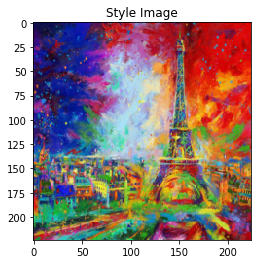

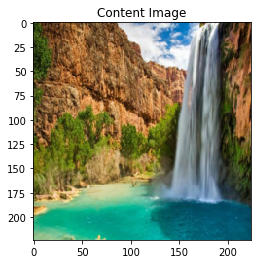

In [ ]:
toPIL = transforms.ToPILImage()  

def display(tensor, title=None):
    image = tensor.cpu().clone()  
    image = image.squeeze(0)    
    image = toPIL(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)

plt.figure()
display(style_image, title='Style Image')

plt.figure()
display(content_image, title='Content Image')


___

### Part 3
Create a classes for the style and content loss

**TODO:**

**DONE:**
* Create a module that calculates the content loss in the forward method, compared to some precalculated targets stored in the class
* Create a module that calculates the style loss in the forward method using a gram matrix, compared to some precalculated targets stored in the class

In [ ]:
def gram_matrix(input):
    n, c, h, w = input.size()
    input = input.view(n*c, h*w)
    
    G = input @ input.T
    G /= n*c*h*w
            
    return G

class ContentLoss(nn.Module):
    def __init__(self, P):
        """
        Input:
        P (tensor): Content Image
        """
        super(ContentLoss, self).__init__()
        self.P = P.detach()
        
    def forward(self, input):
        """
        Input:
        F (tensor): Morphed Image
        """
        self.loss = 0.5 * torch.sum((input - self.P)**2)
        
        return input
        
    
class StyleLoss(nn.Module):
    def __init__(self, A):
        """
        Input:
        A (tensor): Style_Image
        """
        super(StyleLoss, self).__init__()
        self.A = gram_matrix(A).detach()
        
    def forward(self, input):
        """
        Input:
        F (tensor): Morphed Image
        """
        n,c,h,w = input.size()
            
        G = gram_matrix(input)
        self.loss = (1 / 4*(c**2 * (h * w)**2)) * torch.sum((G - self.A)**2)
        
        return input

___

### Part 4
Create and run a method that minimizes the content and style loss for a copy of the content image

Note that the content loss should be zero if you take out the style loss. Why is that?

**TODO:**

* Use an Adam optimizer with learning rate of .1
* Show both the content and the style loss every 50 steps
* Ensure that the outputs don't go out of range (clamp them)
* Display the tensor as an image!

**DONE:**



In [ ]:
def get_intermediates(image, indicies):
    """
    This function will run both the content and style images through the network
    and return the activation layers for use in computing the loss
    """
    gc.collect()
    vgg = VGGIntermediate(requested=indicies).cuda()
    vgg(image)
    
    return vgg.intermediates

In [ ]:
# Choose the layers to use for style and content transfer
default_content_layers = ['conv4_1']
default_style_layers = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']

def transfer_style(content_image, style_image, num_steps=300,\
                   style_weight=1_000_000, content_weight=1, 
                   content_layers=default_content_layers, style_layers=default_style_layers):
    
    vgg_names = ["conv1_1", "relu1_1", "conv1_2", "relu1_2", "maxpool1", "conv2_1", "relu2_1", "conv2_2", "relu2_2", "maxpool2", "conv3_1", "relu3_1", "conv3_2", "relu3_2", "conv3_3", "relu3_3","maxpool3", "conv4_1", "relu4_1", "conv4_2", "relu4_2", "conv4_3", "relu4_3","maxpool4", "conv5_1", "relu5_1", "conv5_2", "relu5_2", "conv5_3", "relu5_3","maxpool5"]
    content_indicies = [vgg_names.index(name) for name in content_layers]
    style_indicies = [vgg_names.index(name) for name in style_layers]
    
    content_target = get_intermediates(content_copy, content_indicies)
    style_target = get_intermediates(style_image, style_indicies)
    combined_indicies = sorted(list(set(content_indicies) | set(style_indicies)))
    
    model = VGGIntermediate(requested=combined_indicies).cuda()
    
    content_loss_funcs = { i : ContentLoss(target) for i, target in content_target.items()}
    style_loss_funcs = { i : StyleLoss(target) for i, target in style_target.items()}

    # Run the optimizer on the images to change the image
    #  using the loss of the style and content layers
    #  to backpropagate errors 
    optimizer = optim.Adam([content_image.requires_grad_()])
    
    run = [0]
    while run[0] <= num_steps:
        
        def closure():
            # Scale Down to 0, 1
            content_image.data.clamp_(0, 1)
            
            optimizer.zero_grad()
            model(content_image)
            
            output_layers = model.intermediates
            
            style_score = torch.zeros(len(style_loss_funcs)).cuda()
            content_score = 0
            
            for index, (i, style_loss) in enumerate(style_loss_funcs.items()):
                style_loss(output_layers[i])
                style_score[index] = style_loss.loss
               
            for i, content_loss in content_loss_funcs.items():
                content_loss(output_layers[i])
                temp = content_loss.loss
                content_score += temp
                
            style_score = style_score.mean() * style_weight
            content_score *= content_weight
            
            total_loss = style_score + content_score
            total_loss.backward()
            
            run[0] += 1
            if run[0] % 50 == 0:
                print("epoch " + str(run[0]) + ":")
                print("Style Loss : " + str(style_score) + 
                      " Content Loss: " + str(content_score))
                print("Total Loss: " + str(total_loss))
                
            return total_loss
        
        optimizer.step(closure)
    
    # Scale down to 0, 1
    content_image.data.clamp_(0, 1)
    
    return content_image
            
  


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


epoch 50:
Style Loss : tensor(223.5672, device='cuda:0', grad_fn=<MulBackward0>) Content Loss: tensor(117.9259, device='cuda:0', grad_fn=<MulBackward0>)
Total Loss: tensor(341.4931, device='cuda:0', grad_fn=<AddBackward0>)
epoch 100:
Style Loss : tensor(85.8066, device='cuda:0', grad_fn=<MulBackward0>) Content Loss: tensor(108.3843, device='cuda:0', grad_fn=<MulBackward0>)
Total Loss: tensor(194.1909, device='cuda:0', grad_fn=<AddBackward0>)
epoch 150:
Style Loss : tensor(50.8864, device='cuda:0', grad_fn=<MulBackward0>) Content Loss: tensor(101.8565, device='cuda:0', grad_fn=<MulBackward0>)
Total Loss: tensor(152.7429, device='cuda:0', grad_fn=<AddBackward0>)
epoch 200:
Style Loss : tensor(37.6928, device='cuda:0', grad_fn=<MulBackward0>) Content Loss: tensor(98.1053, device='cuda:0', grad_fn=<MulBackward0>)
Total Loss: tensor(135.7982, device='cuda:0', grad_fn=<AddBackward0>)
epoch 250:
Style Loss : tensor(31.8392, device='cuda:0', grad_fn=<MulBackward0>) Content Loss: tensor(95.4270

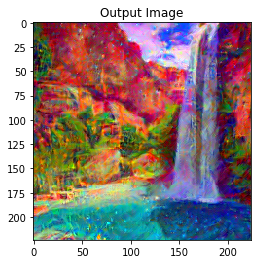

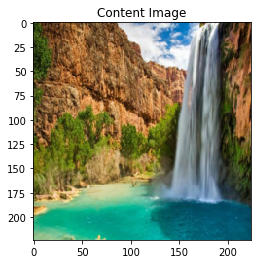

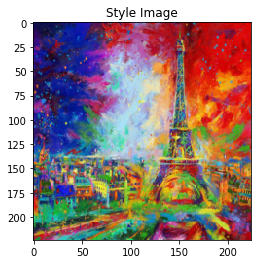

In [ ]:
# Start with a copy of the content image
content_copy = deepcopy(content_image).cuda()

output_image = transfer_style(content_copy, style_image)
# Show the image
plt.figure()
display(output_image, title='Output Image')
plt.figure()
display(content_image, title='Content Image')
plt.figure()
display(style_image, title='Style Image')

### Part 5

**TODO:**

- Describe equation (1) on p. 10 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (3) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (4) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (5) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.

**DONE:**

$$\mathcal{L}_{content}(\vec{p},\vec{x},l) = \sum_{i,j}\frac{1}{2}(F_{ij}^{l}-P_{ij}^{l})^2 = \sum_{i=1}^{N_{l}}\sum_{j}^{M_{l}}\frac{1}{2}(F_{ij}^{l}-P_{ij}^{l})^2$$

This function is the content Loss calculated given the original image **p**, the generate image **x** and the layer $l$. It is calculated by summing over the $N_{l}$ filters and the $M_{l}$ positions in those filters and computing one half the difference of the generated image feature representation and the original image's feature representation at the $l$th layer both at their respective $i$th filter and $j$th position all squared.

$$G_{ij}^{l} = \sum_{k}(F_{ik}^{l}F_{jk}^{l})$$

This is the formula for the Gram matrix where G represents the inner product between the generated image's feature maps $i$ and $j$ in layer $l$. 

$$E_{l} = \frac{1}{4N_{l}^{2}M_{l}^{2}}\sum_{i,j}(G_{ij}^{l} - A_{ij}^{l})^{2}$$

Here $E_{l}$ is the contribution of the $l$th layer to the total loss where $N_{l}$ is the number of filters and $M_{l}$ is the height times width of the feature maps, $G_{ij}^{l}$ is the $i$th filter at the $j$th position of style representation of the $l$th layer of the image generated and $A_{ij}^{l}$ is the   the $i$th filter at the $j$th position of style representation of the $l$th layer of the original image. 

$$\mathcal{L}_{style}(\vec{a}, \vec{x}) = \sum_{l = 0}^{L}w_{l}E_{l}$$

This is the total loss of the style by summing over the L layers and multiplying the $E_{l}$ contributions to $w_{l}$ which are the weight factors of each $E_{l}$. 
